## Solving MNIST with TensorFlow

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

Load the MNIST data:

In [2]:
BATCH_SIZE = 100
eta = 0.001
data_dir = '../MNIST_data/'
mnist = input_data.read_data_sets(data_dir,
                                  one_hot=True,
                                  fake_data=False)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


Let's see what we have here:

In [4]:
print mnist.train.images.shape

(55000, 784)


In [5]:
def matrix_show(image):
    for y in image:
        print ''.join(['%4d'%x for x in y])
matrix_show(100*mnist.train.images[1].reshape((28,28)))

   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0  12  51  99  99  99  83  32   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   8  55  91  98  99  98  99  98  87   7   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  48  99  99  99  99  87  79  79  87 100  83   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  79  99  98  99  83   7   0   0  23  99  98   0   0   0

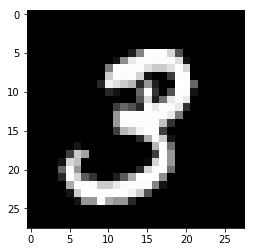

[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


In [6]:
plt.imshow(mnist.train.images[1].reshape((28,28)), cmap='gray')
plt.show()
print mnist.train.labels[1]

In [7]:
mnist.validation.images.shape

(5000, 784)

In [8]:
mnist.test.images.shape

(10000, 784)

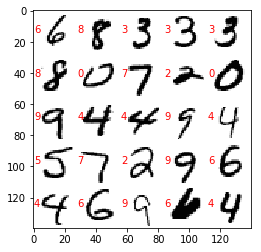

In [10]:
def show_images(imgs, labels):
    N=imgs.shape[0]
    w=int(np.ceil(np.sqrt(N)))
    h=N/w
    imgs.shape=(N, 28,28)

    rows = [ np.hstack(imgs[i:i+w,:,:]) for i in range(0,w*h, w)]
    tiled = np.vstack(rows)
    plt.imshow(1.0 - tiled, cmap='gray')
    
    labels=np.argmax(labels, axis=1)
    for i in range(w):
        for j in range(h):
            plt.text(i*28, 14+j*28, '%s'%labels[j*w+i], color=(1,0,0))
    plt.show()
#%pylab inline
#pylab.rcParams['figure.figsize'] = (10,10)  
idx = np.random.randint(0, 55000, 25)
show_images(mnist.train.images[idx], mnist.train.labels[idx])

# Define a graph to classify images

In [11]:
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None, 784], name='x')
    y = tf.placeholder(tf.float32, [None, 10], name='y')

Define some useful functions:

In [12]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
      mean = tf.reduce_mean(var)
      tf.summary.scalar('mean', mean)
      with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
      tf.summary.scalar('stddev', stddev)
      tf.summary.scalar('max', tf.reduce_max(var))
      tf.summary.scalar('min', tf.reduce_min(var))
      tf.summary.histogram('histogram', var)

In [13]:
def affine_layer(input_tensor, output_dim, layer_name, act=tf.nn.relu):
    """
    Build one simple Affine layer: y = W*x + b
    Adds non-linearity and collects statistics
    """
    input_shape = input_tensor.get_shape().as_list()
    input_dim = input_shape[-1]

    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
        # This Variable will hold the state of the weights for the layer
        with tf.name_scope('weights'):
            shape = [input_dim, output_dim]
            init = tf.truncated_normal(shape, stddev=0.1)
            weights = tf.Variable(init)
            #variable_summaries(weights)
        with tf.name_scope('biases'):
            initial = tf.constant(0.1, shape=[output_dim])
            biases = tf.Variable(initial)
            #variable_summaries(biases)
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights) + biases
            #tf.summary.histogram('pre_activations', preactivate)
    activations = act(preactivate, name='activation')
    #tf.summary.histogram('activations', activations)
    print "Added Affine layer %d -> %d with %s" % (input_dim, output_dim, act.func_name)
    return activations

### Define our simple network

In [14]:
hidden = affine_layer(x, 500, 'hidden')
prediction = affine_layer(hidden, 10, 'pred', act=tf.identity)

Added Affine layer 784 -> 500 with relu
Added Affine layer 500 -> 10 with identity


In [15]:
sess = tf.InteractiveSession()

We built an "inference" function that receives a batch of images and returns a tensorflow object of the prediction. 

The next component is creating a loss function.

In [17]:
def create_loss(predict, labels):
    # The raw formulation of cross-entropy,
    #
    # tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.softmax(y)),
    #                               reduction_indices=[1]))
    #
    # can be numerically unstable.
    #
    # So here we use tf.nn.softmax_cross_entropy_with_logits on the
    # raw outputs of the nn_layer above, and then average across
    # the batch.
    diff = tf.nn.softmax_cross_entropy_with_logits(labels=labels, 
                                                   logits=predict)
    with tf.name_scope('total'):
        cross_entropy = tf.reduce_mean(diff)
    tf.summary.scalar('cross_entropy', cross_entropy)
    return cross_entropy
  

In [18]:
loss = create_loss(prediction, y)

In [19]:
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(eta).minimize(loss)
    #train_step = tf.train.GradientDescentOptimizer(eta).minimize(loss)

In [20]:
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(prediction, 1))
accuracy = 100.0 * tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('accuracy', accuracy)
merged = tf.summary.merge_all()

Merge all the summaries and start training:

In [21]:
log_dir = './tensorboard/'
if tf.gfile.Exists(log_dir):  # Delete previous runs
    import shutil
    shutil.rmtree(log_dir)
tf.gfile.MakeDirs(log_dir)

train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
test_writer = tf.summary.FileWriter(log_dir + '/test')

tf.global_variables_initializer().run()

In [22]:
acc_list = []
for i in range(1000):
    xs, ys = mnist.train.next_batch(BATCH_SIZE)
    ys = ys.astype(np.float32)
    summary, acc, _ = sess.run([merged, accuracy, train_step], 
                               feed_dict={x:xs, y:ys})
    acc_list.append(acc)
    train_writer.add_summary(summary, i)
    if i % 20 == 0:   # Measure accuracy on the test set
        summary, test_acc = sess.run([merged, accuracy], 
                                     feed_dict={x:mnist.test.images, 
                                                y:mnist.test.labels})
        test_writer.add_summary(summary, i)
        print('Accuracy at iteration %4d: %6s%%  (train is %6s%%)' % (i, test_acc, np.mean(acc_list)))
        acc_list=[]
train_writer.flush()
test_writer.flush()    

Accuracy at iteration    0:  13.25%  (train is    8.0%)
Accuracy at iteration   20:  84.33%  (train is   64.5%)
Accuracy at iteration   40:  88.34%  (train is  85.65%)
Accuracy at iteration   60:  90.43%  (train is   87.7%)
Accuracy at iteration   80:  91.21%  (train is   90.3%)
Accuracy at iteration  100:  91.69%  (train is   91.7%)
Accuracy at iteration  120:  92.02%  (train is   92.9%)
Accuracy at iteration  140:  92.68%  (train is   91.8%)
Accuracy at iteration  160:  93.09%  (train is  92.85%)
Accuracy at iteration  180:  93.62%  (train is  92.35%)
Accuracy at iteration  200:  93.61%  (train is  93.45%)
Accuracy at iteration  220:  93.96%  (train is   92.9%)
Accuracy at iteration  240:  94.21%  (train is  93.45%)
Accuracy at iteration  260:  94.39%  (train is  94.55%)
Accuracy at iteration  280:  94.45%  (train is  93.05%)
Accuracy at iteration  300:  94.51%  (train is   95.0%)
Accuracy at iteration  320:  93.96%  (train is  94.35%)
Accuracy at iteration  340:  94.98%  (train is  

### (tensorBoard)

# Let's look at some predictions

In [23]:
xs, ys = mnist.test.next_batch(BATCH_SIZE)
ys = ys.astype(np.float32)

In [24]:
pred = sess.run(prediction, feed_dict={x:xs})
errors = np.argmax(pred, axis=1) != np.argmax(ys, axis=1)
print np.sum(errors)

2


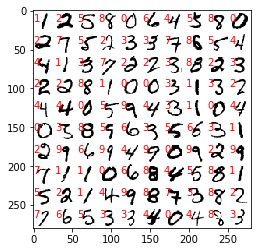

In [25]:
show_images(xs, pred)

In [26]:
np.nonzero(errors)

(array([17, 53]),)

In [27]:
pred = sess.run(prediction, feed_dict={x:mnist.test.images})

(304, 784)
Error rate is 3.04%


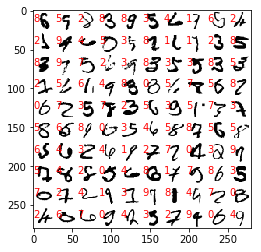

In [29]:
errors = np.argmax(mnist.test.labels, axis=1) != np.argmax(pred, axis=1)
errors = np.nonzero(errors)
xs = mnist.test.images[errors]
ys = pred[errors]
print xs.shape
print 'Error rate is %.2f%%'%(100.0*len(xs) / len(mnist.test.labels))
show_images(xs[:100], ys[:100])

So we have a simple, nearly linear, classifier

# LeNet

Lenet has convolutions and max-pooling layers

Let's reset TensorFlow:

In [30]:
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None, 784], name='x-input')
    y = tf.placeholder(tf.float32, [None, 10], name='y-input')

Define a convolutional layer:

In [31]:
def conv_layer(input_tensor, output_channels, layer_name, 
               ksize=5, stride=1, act=tf.nn.relu):
    input_shape = input_tensor.get_shape().as_list()
    input_channels = input_shape[-1]
    with tf.name_scope(layer_name):
        weights = tf.Variable(
            tf.truncated_normal([ksize, ksize, input_channels, 
                                 output_channels],
                                stddev=1.0 / np.sqrt(float(input_channels))),name='weights')
        biases = tf.Variable(tf.zeros([output_channels]),name='biases')
        c = tf.nn.conv2d(input_tensor, weights, 
                         strides=[1, stride, stride, 1], padding='SAME') + biases
        print "Added Conv layer %dx%dx %d --%dx%d--> %d with %s" % (input_shape[1], input_shape[2], input_shape[3], 
                                                                    ksize, ksize,
                                                                    output_channels, act.func_name)
        return act(c)

def flatten_layer(x, layer_name):
    x_shape = x.get_shape().as_list()
    new_shape = [-1, np.product(x_shape[1:])]
    print "Added Flatten layer %dx%d%d -> %d"% (x_shape[1], x_shape[2], x_shape[3], new_shape[1])
    with tf.name_scope(layer_name):
        out = tf.reshape(x, new_shape)
    return out

In [32]:
def inference(x):
    images = tf.reshape(x, [-1, 28, 28, 1])
    #tf.summary.image('input', images, 10)
    conv1 = conv_layer(images, 20, 'conv1', ksize=3) #, act=tf.identity)
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME') 
    conv2 = conv_layer(pool1, 50, 'conv2', ksize=3) # , act=tf.identity)
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
    flat_pool = flatten_layer(pool2, 'flatten')
    aff = affine_layer(flat_pool, 500, 'affine')
    predict = affine_layer(aff, 10, 'predict', act=tf.identity)
    return predict

In [34]:
prediction = inference(x)

Added Conv layer 28x28x 1 --3x3--> 20 with relu
Added Conv layer 14x14x 20 --3x3--> 50 with relu
Added Flatten layer 7x750 -> 2450
Added Affine layer 2450 -> 500 with relu
Added Affine layer 500 -> 10 with identity


Redefine the loss etc:

In [35]:
loss = create_loss(prediction, y)
train_step = tf.train.AdamOptimizer(eta).minimize(loss)
#train_step = tf.train.GradientDescentOptimizer(eta).minimize(loss)
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(prediction, 1))
accuracy = 100.0 * tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
train_writer = tf.summary.FileWriter(log_dir + '/trainLenet', sess.graph)
test_writer = tf.summary.FileWriter(log_dir + '/testLenet')

tf.global_variables_initializer().run()

In [36]:
acc_list = []
for i in range(1000):
    xs, ys = mnist.train.next_batch(BATCH_SIZE)
    ys = ys.astype(np.float32)
    acc, _ = sess.run([accuracy, train_step], feed_dict={x:xs, y:ys})
    acc_list.append(acc)
    summary = tf.Summary(value=[tf.Summary.Value(tag='accuracy', simple_value=acc)])
    train_writer.add_summary(summary, i)
    if i % 20 == 0:   # Measure accuracy on the test set
        test_acc = sess.run(accuracy, feed_dict={x:mnist.test.images, y:mnist.test.labels})
        summary = tf.Summary(value=[tf.Summary.Value(tag='accuracy', simple_value=test_acc)])
        test_writer.add_summary(summary, i)
        print 'Accuracy at iteration %3d: %6s  (train is %6s)' % (i, test_acc, np.mean(acc_list))
        acc_list = []
train_writer.flush()
test_writer.flush()


Accuracy at iteration   0:  15.26  (train is    5.0)
Accuracy at iteration  20:  73.09  (train is   57.7)
Accuracy at iteration  40:  88.83  (train is   81.3)
Accuracy at iteration  60:  90.84  (train is  87.85)
Accuracy at iteration  80:  91.57  (train is   91.2)
Accuracy at iteration 100:  93.58  (train is   92.3)
Accuracy at iteration 120:  93.45  (train is   93.2)
Accuracy at iteration 140:  93.19  (train is  93.55)
Accuracy at iteration 160:  93.85  (train is  93.25)
Accuracy at iteration 180:  93.24  (train is  93.95)
Accuracy at iteration 200:  95.46  (train is  94.35)
Accuracy at iteration 220:  96.09  (train is  95.65)
Accuracy at iteration 240:  95.11  (train is  95.05)
Accuracy at iteration 260:  95.73  (train is   95.3)
Accuracy at iteration 280:  96.05  (train is   95.8)
Accuracy at iteration 300:  96.33  (train is  96.05)
Accuracy at iteration 320:  95.76  (train is   95.9)
Accuracy at iteration 340:  96.41  (train is   95.0)
Accuracy at iteration 360:  96.57  (train is  

(247, 784)
Error rate is 2.47%


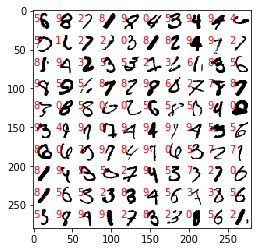

In [37]:
pred = sess.run(prediction, feed_dict={x:mnist.test.images})
errors = np.argmax(mnist.test.labels, axis=1) != np.argmax(pred, axis=1)
errors = np.nonzero(errors)
xs = mnist.test.images[errors]
ys = pred[errors]
print xs.shape
print 'Error rate is %.2f%%'%(100.0*len(xs) / len(mnist.test.labels))
show_images(xs[:100], ys[:100])